In [1]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

from torch.utils import data
from torchvision import datasets, transforms as T

import random, os, time, json, sys
from tqdm import tqdm
# from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [3]:
mnist_transform = T.Compose([
    T.ToTensor(),
#     T.Normalize(
#         mean=[0.5,],
#         std=[0.5,],
#     ),
])

train_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [4]:
# train = train_dataset.data.reshape(-1, 28*28)
# test = test_dataset.data.reshape(-1, 28*28)

In [5]:
train_loader = data.DataLoader(train_dataset, num_workers=4, batch_size=1000)
test_loader = data.DataLoader(test_dataset, num_workers=4, batch_size=1000)

In [6]:
from scipy.spatial import Delaunay, ConvexHull

In [7]:
for xx, yy in train_loader:
    xx = xx.view(-1, 28*28)
    print(xx.shape, yy.shape)
    break

torch.Size([1000, 784]) torch.Size([1000])


In [8]:
N, D = 1000, 5
xx = torch.randn(N, D)

In [9]:
train_hull = Delaunay(xx, incremental=True)

In [10]:
train_hull.find_simplex(torch.randn(N, D)).shape

(1000,)

In [11]:
train_hull.add_points(torch.randn(N, D))

## Find PCA of MNIST

In [12]:
# train_dataset.data.to(torch.float32)/255*2-1

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components=6)
pca.fit(train_dataset.data.reshape(-1, 784).to(torch.float32)/255*2-1)
pca

PCA(n_components=6)

In [12]:
## select samples uniformly
def get_uniform_samples(dataset, num_samples):
    samples = []
    num_per_class = num_samples//10 ## 100*10
    for i in range(10):
        cls_idx = torch.nonzero(dataset.targets == i)
        cls_idx = torch.randperm(len(cls_idx))[:num_per_class]
        samples += [dataset.data[cls_idx]]
    samples = torch.cat(samples, dim=0)
    samples = samples.reshape(-1, 784).to(torch.float32)/255*2-1
    return samples

In [13]:
xx = get_uniform_samples(train_dataset, num_samples=1000)
xx.shape

torch.Size([1000, 784])

In [14]:
test_xx = get_uniform_samples(test_dataset, num_samples=1000)

In [15]:
pca.transform(test_xx).shape

NameError: name 'pca' is not defined

In [19]:
train_hull = Delaunay(pca.transform(xx))
inside = (train_hull.find_simplex(pca.transform(test_xx)) >= 0)

frac = inside.astype(float).mean()
frac

0.532

## Do this in Loop

In [20]:
# N, D = 1000, 6
N = 1000
# for D in range(2,7+1):
for D in range(2,6+1):
    pca = PCA(n_components=D)
    xdata = train_dataset.data.reshape(-1, 784).to(torch.float32)/255*2-1
    pca.fit(xdata)

    ## Testing for TEST dataset inside convex hull of TRAIN dataset
    xx = get_uniform_samples(train_dataset, num_samples=N)
    test_xx = get_uniform_samples(test_dataset, num_samples=N)

    ## Testing for TRAIN dataset inside convex hull of TEST dataset
#     xx = get_uniform_samples(test_dataset, num_samples=N)
#     test_xx = get_uniform_samples(train_dataset, num_samples=N)

    train_hull = Delaunay(pca.transform(xx))
    inside = (train_hull.find_simplex(pca.transform(test_xx)) >= 0)

    frac = inside.astype(float).mean()
    
    print(f"N={N}, dim={D}, inside_frac: {frac}")

N=1000, dim=2, inside_frac: 0.994
N=1000, dim=3, inside_frac: 0.932
N=1000, dim=4, inside_frac: 0.829
N=1000, dim=5, inside_frac: 0.753
N=1000, dim=6, inside_frac: 0.525


In [ ]:
## Outputs
"""
Using PCA
N=1000, dim=2, inside_frac: 0.988
N=1000, dim=3, inside_frac: 0.952
N=1000, dim=4, inside_frac: 0.847
N=1000, dim=5, inside_frac: 0.678
N=1000, dim=6, inside_frac: 0.554
N=1000, dim=7, inside_frac: 0.357

```On Test/Train Reversed
N=1000, dim=2, inside_frac: 0.954
N=1000, dim=3, inside_frac: 0.927
N=1000, dim=4, inside_frac: 0.745
N=1000, dim=5, inside_frac: 0.638
N=1000, dim=6, inside_frac: 0.495
N=1000, dim=7, inside_frac: 0.348

Using Random Linear Transform
N=1000, dim=2, inside_frac: 0.989
N=1000, dim=3, inside_frac: 0.979
N=1000, dim=4, inside_frac: 0.902
N=1000, dim=5, inside_frac: 0.841
N=1000, dim=6, inside_frac: 0.795
N=1000, dim=7, inside_frac: 0.632

Using Dist Tranf Base
N=1000, dim=2, inside_frac: 0.987
N=1000, dim=3, inside_frac: 0.958
N=1000, dim=4, inside_frac: 0.888
N=1000, dim=5, inside_frac: 0.766
N=1000, dim=6, inside_frac: 0.714
N=1000, dim=7, inside_frac: 0.516

```Initialized With Data
N=1000, dim=2, inside_frac: 0.986
N=1000, dim=3, inside_frac: 0.951
N=1000, dim=4, inside_frac: 0.939
N=1000, dim=5, inside_frac: 0.778
N=1000, dim=6, inside_frac: 0.792
N=1000, dim=7, inside_frac: 0.61

DT min exp with Data


"""

print()

In [16]:
sys.path.append("../Spatial_Neurons/")
import dtnnlib as dtnn

In [17]:
# N, D = 1000, 6
N = 1000
# for D in range(2,7+1):
for D in range(2,6+1):
#     func = nn.Linear(784, D)
#     func = nn.Sequential(
#                 nn.Linear(784, 790),
#                 nn.Linear(790, D)
#             )
    
    ## center init funcs
#     func = dtnn.DistanceTransformBase(784, D)
#     func = dtnn.DistanceTransform_MinExp(784, D)
#     func.centers.data = get_uniform_samples(train_dataset, 10)[torch.randperm(10)[:D]]
    func = dtnn.StereographicTransform(784, D)


    ## Testing for TEST dataset inside convex hull of TRAIN dataset
    xx = get_uniform_samples(train_dataset, num_samples=N)
    test_xx = get_uniform_samples(test_dataset, num_samples=N)

    ## Testing for TRAIN dataset inside convex hull of TEST dataset
#     xx = get_uniform_samples(train_dataset, num_samples=N)
#     test_xx = get_uniform_samples(test_dataset, num_samples=N)
    
    xx = func(xx).data
    test_xx = func(test_xx).data
    train_hull = Delaunay(xx)
    inside = (train_hull.find_simplex(test_xx) >= 0)

    frac = inside.astype(float).mean()
    
    print(f"N={N}, dim={D}, inside_frac: {frac}")

N=1000, dim=2, inside_frac: 0.982
N=1000, dim=3, inside_frac: 0.944
N=1000, dim=4, inside_frac: 0.918
N=1000, dim=5, inside_frac: 0.774
N=1000, dim=6, inside_frac: 0.719


In [ ]:
asdsad

## After performing kNN scaling of activations

In [23]:
def get_sigma(dists, k=50, epoch=700, lr=0.03):
    dists = torch.topk(dists, k=k,dim=1)[0]
    sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*0.2)
    optim = torch.optim.Adam([sigma], lr=lr)
    target = torch.log2(torch.ones_like(sigma)*k).to(dists.device)
#     print(sigma, target)
    for i in range(epoch):
        delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
#         print(sigma.data, delta.data)
        delta = delta-target

        optim.zero_grad()
        error = (delta**2).sum()
        error.backward()
        optim.step()
#     print(sigma, delta)
    return sigma.data

In [24]:
selected_points = get_uniform_samples(train_dataset, num_samples=790)
selected_points.shape

torch.Size([790, 784])

In [25]:
transform = dtnn.DistanceTransformBase(28*28, len(selected_points))
transform.centers.data = selected_points

In [26]:
# transform = nn.Linear(28*28, len(selected_points))
# transform.weight.data = selected_points

In [27]:
xx = get_uniform_samples(train_dataset, 1000)

In [28]:
with torch.no_grad():
    dists = transform(xx)
dists.shape

torch.Size([1000, 790])

In [29]:
dists = dists-dists.min(dim=1, keepdim=True)[0]
##### dists = torch.topk(dists, k=50,dim=1)[0]

sigma = get_sigma(dists, k=784)
topk_dists = torch.exp(-dists/sigma)
# topk_dists = dists

In [30]:
topk_dists.shape

torch.Size([1000, 790])

In [31]:
D = 5
linear_proj = nn.Linear(len(selected_points), D)
with torch.no_grad():
    lowdim_dist = linear_proj(topk_dists)
lowdim_dist.shape

torch.Size([1000, 5])

In [32]:
train_hull = Delaunay(lowdim_dist.data)

In [33]:
test_xx = get_uniform_samples(test_dataset, num_samples=N)
with torch.no_grad():
    _dists = transform(test_xx)
_dists = _dists-_dists.min(dim=1, keepdim=True)[0]

_sigma = get_sigma(_dists, k=784)
_topk_dists = torch.exp(-_dists/_sigma)    
# _topk_dists = _dists

with torch.no_grad():
    _lowdim_dist = linear_proj(_topk_dists)
    
### Check if inside hull
inside = (train_hull.find_simplex(_lowdim_dist) >= 0)
frac = inside.astype(float).mean()
D, frac

(5, 0.822)

In [34]:
### Using UMAP embedding

In [35]:
embed = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.1, spread=1)
embedding = embed.fit_transform(xx)

In [36]:
embedding.shape, lowdim_dist.shape

((1000, 2), torch.Size([1000, 5]))

In [37]:
embedding_test = embed.transform(test_xx)

In [38]:
np.concatenate([embedding, lowdim_dist], axis=-1).shape

(1000, 7)

In [39]:
np.concatenate([embedding_test, _lowdim_dist], axis=-1).shape

(1000, 7)

In [40]:
# train_hull = Delaunay(embedding)
# inside = (train_hull.find_simplex(embedding_test) >= 0)

train_hull = Delaunay(np.concatenate([embedding, lowdim_dist], axis=-1))
inside = (train_hull.find_simplex(np.concatenate([embedding_test, _lowdim_dist], axis=-1)) >= 0)

frac = inside.astype(float).mean()
frac

0.459

In [41]:
# def is_in_convex_hull_batch(new_samples: np.array, 
#                             hull_samples: np.array) -> np.array:
#   """
#   Returns a vector of size new_samples.shape[0] (the number of new samples),
#   with a boolean indicating whether or not the sample lies in the convex hull.
#   """
#   assert new_samples.shape[1] == hull_samples.shape[1],  \
#   "Dimensions of new sample and convex hull samples should be the same, "
#   "but are %d and %d" % (new_samples.shape[1], samples.shape[1])
#   if not isinstance(hull_samples, Delaunay):
#     hull = Delaunay(hull_samples)
#   return hull.find_simplex(new_samples) >= 0

In [42]:
xx.min(), xx.max()

(tensor(-1.), tensor(1.))

In [43]:
train_dataset.data.shape, train_dataset.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [11]:
embed = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.1, spread=1)
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [12]:
selected_points = test_dataset.data.reshape(-1, 28*28).type(torch.float32)/255
embedding = embed.fit_transform(selected_points)
# embedding = embed.fit_transform(centers, output_cent)

In [13]:
for xx, yy in train_loader:
    xx = xx.reshape(-1, 28*28)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 784]) torch.Size([50])


In [14]:
xx.max()

tensor(1.)

In [15]:
xtransf = embed.transform(xx.numpy().reshape(-1, 28*28))

In [16]:
xx.max()

tensor(1.)

In [18]:
# sigma = get_sigma(dists)

In [19]:
!mkdir outputs/03.4_visualize

mkdir: cannot create directory ‘outputs/03.4_visualize’: File exists


## Get scale to top-k points

In [28]:
topk_dists.max(), topk_dists.min()

(tensor(1.), tensor(4.3349e-26))

In [29]:
i = -1

index:9/50


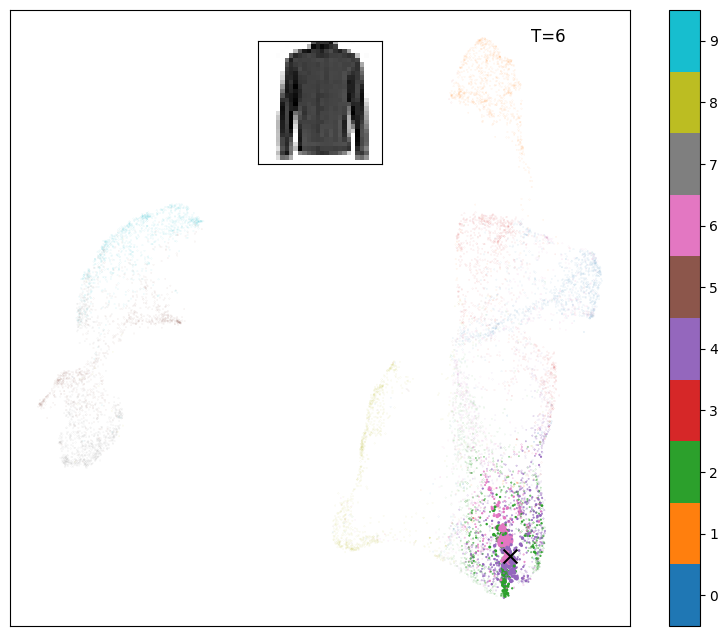

In [39]:
i += 1
activ = topk_dists[i].data.cpu().numpy()

print(f"index:{i}/{len(dists)}")
fig = plt.figure(figsize=(10,8))

plt.scatter(embedding[:,0], embedding[:, 1], c=test_dataset.targets, s=np.maximum(activ*80, 0.001), cmap="tab10")
#     plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.0), cmap="tab10")

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

ins = plt.gca().inset_axes([0.4,0.75,0.2,0.2])
ins.imshow(xx[i].numpy().reshape(28, 28), cmap='gray_r')
ins.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.scatter(xtransf[i,0], xtransf[i,1], marker='x', color='k', s=100)

plt.text(.84, .97, f'T={int(yy[i])}', ha='left', va='top', transform=fig.axes[0].transAxes, fontsize="large")
plt.show()